In [ ]:
!pip install tensorflow

In [ ]:
!pip install pandas_datareader

In [ ]:
!pip install yfinance

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

/Users/sidkumar/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-12-06 18:22:54.537797: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Fetch historical stock data
symbol = "AAPL"
start_date = "2020-01-01"
end_date = "2023-01-01"
data = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Use only the 'Close' prices for simplicity
close_prices = data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

In [4]:
# Function to prepare data for LSTM
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        a = data[i:(i + time_steps), 0]
        X.append(a)
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Set the number of time steps
time_steps = 10

In [5]:
# Prepare the training data
X, y = prepare_data(scaled_data, time_steps)

# Reshape the data for LSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [6]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [7]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Make predictions on the test set
predictions = model.predict(X_test)

Epoch 1/20
19/19 [==============================] - 22s 24ms/step - loss: 0.1006
Epoch 2/20
19/19 [==============================] - 1s 29ms/step - loss: 0.0071
Epoch 3/20
19/19 [==============================] - 1s 30ms/step - loss: 0.0035
Epoch 4/20
19/19 [==============================] - 1s 33ms/step - loss: 0.0020
Epoch 5/20
19/19 [==============================] - 1s 28ms/step - loss: 0.0017
Epoch 6/20
19/19 [==============================] - 0s 25ms/step - loss: 0.0017
Epoch 7/20
19/19 [==============================] - 1s 30ms/step - loss: 0.0017
Epoch 8/20
19/19 [==============================] - 1s 27ms/step - loss: 0.0017
Epoch 9/20
19/19 [==============================] - 0s 25ms/step - loss: 0.0018
Epoch 10/20
19/19 [==============================] - 1s 26ms/step - loss: 0.0017
Epoch 11/20
19/19 [==============================] - 1s 30ms/step - loss: 0.0016
Epoch 12/20
19/19 [==============================] - 1s 31ms/step - loss: 0.0016
Epoch 13/20
19/19 [=================

In [8]:
# Invert the normalization for better visualization
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

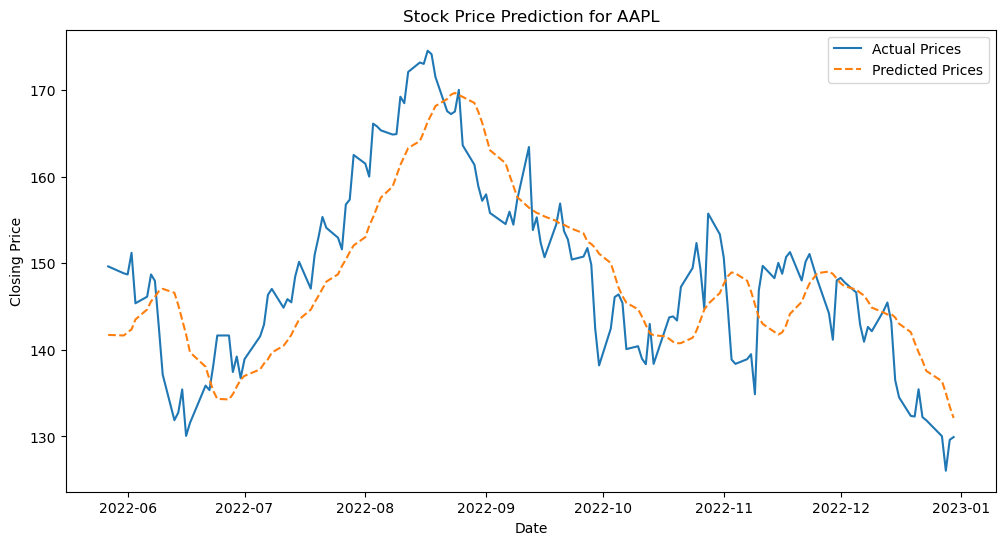

In [9]:
# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(data.index[split_index + time_steps:], y_test, label='Actual Prices')
plt.plot(data.index[split_index + time_steps:], predictions, label='Predicted Prices', linestyle='--')
plt.title(f'Stock Price Prediction for {symbol}')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()